In this notebook on classification models, we will use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"].to_numpy(), mnist["target"]

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

To display one of the images in the dataset, use this code:

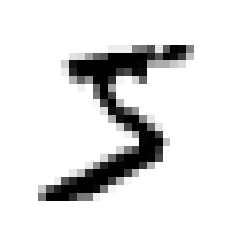

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

It looks like a '5'.

In [5]:
y[0]

'5'

It's indeed a '5' as per the true label.

Label is a string.  Let's convert it to a numeric value, since the ML algorithm expects it so.

In [6]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

Let's split the dataset into training and test sets, and keep the test set aside.  Note that the dataset is already shuffled, so we don't need to divide the strata.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We'll create a '5'-identifier, which means we'll categorise the labels into '5's and non-'5's

In [8]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

**SGDClassifier** is ideally suited to learn large amounts of data.  It's also well suited for online learning, since it learns by one datapoint at a time.  So, let's train one on this dataset 

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

and use it to predict

In [10]:
sgd_clf.predict([some_digit])

array([ True])

The model prediction is correct.  It's a 5 indeed.  That's good news!

## Measuring Accuracy using cross-validation

We'll do K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

However, *Accuracy* isn't a good metric in case of classification models, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). *ConfusionMatrix* happens to be a much better/safer option.

To create a *ConfusionMatrix*, we've to predict the digits.  So, let's use **cross_val_predict** function.  Just like the **cross_val_score** function, **cross_val_predict** performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Create the confusion matrix now

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

A more concise set of metrics would be compute precision and recall

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

In [14]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


Thus, when it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

Instead of two separate metrics, we can use a single metric F1-score, which is a harmonic mean of precision and recall.  

F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

F1-score will be high only if both precision and recall are high.

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Unfortunately, you can't have both high precision and high recall.  There would always a precision-recall tradeoff.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

If you set threshold to 0, the prediction is True

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

However, if you set threshold to a higher value (say, 8000), the prediction becomes False

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? 

First, use the **cross_val_predict** function to get all the decision scores, and then use the **precision_recall_curve** function to compute precision and recall for all possible thresholds.

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot the *precision-recall curve* now.

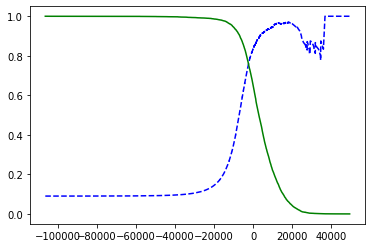

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Suppose you decide to aim for 90% precision.  Find the threshold that gives this precision as follows.

In [22]:
threshold_custom_precision = thresholds[np.argmax(precisions >= 0.8)]

In [23]:
y_train_pred_custom = (y_scores >= threshold_custom_precision)
print(precision_score(y_train_5, y_train_pred_custom))
print(recall_score(y_train_5, y_train_pred_custom))
print(f1_score(y_train_5, y_train_pred_custom))

0.8
0.7127836192584394
0.7538776704711736


## The ROC Curve

TBD

## Multi-class (Multinomial) classification

Some algorithms (such as **LogisticRegression**, **RandomForestClassifier**, and *NaiveBayes classifiers*) are capable of handling multiple classes natively. Others (such as **SGDClassifier** or *SVM classifiers*) are strictly binary classifiers.

Binary classifiers can handle multi-class classifiers using the following techniques.
- One Vs Rest (OVR) - Build a model for each class (a 0-detector, a 1-detector, a 2-detector, and so on), and the highest decision score on the test example will be the predicted class.

- One Vs One (OVO) - Build a model for each pair of classes (to distinguish between 0s and 1s, 0s and 2s, and so on).  If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers.  The class that wins the most duels on the test example will be the predicted class.

For most binary classifiers, OVR is preferred.

Some classifiers (such as SVM) scale poorly with the size of the training set, in which OVO is is preferred.

In [24]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1).

In [25]:
some_digit_scores = svm_clf.decision_function([some_digit])
svm_clf.classes_[np.argmax(some_digit_scores)]

5

SGD also could do that, but using OVR.

In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1).

In [27]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Here's the accuracy of the model

In [28]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])